In [87]:
import requests
import json
from pprint import pprint
import pandas as pd

def priceToken0(swap):
    """
    Converting from Uniswap's SqrtPriceX96 quantity
    to a de-sqrt'ed, de-X96'ed, and de-decimalized number.
    
    This gives the price of token1 in units of token0.
    
    Reference: https://docs.uniswap.org/sdk/v3/guides/fetching-prices
    """
    d0 = int(swap["pool"]["token0"]["decimals"])
    d1 = int(swap["pool"]["token1"]["decimals"])

    p_smol = float(swap["sqrtPriceX96"])**2 / (2**192)
    
    p = p_smol * (10**(-d1)) / (10**(-d0))
    
    return p

def priceToken1(swap):
    """
    This gives the price of token1 in units of token0.
    """
    return 1/priceToken0(swap)

def prepswapdata(swaps):    
    rows = []
    router_addresses = {
        "0xe592427a0aece92de3edee1f18e0157c05861564": "V3 router 1", # V3 router
        "0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45": "V3 router 2", # V3 router 2
        "0x881d40237659c251811cec9c364ef91dc08d300c": "Metamask Router", # metamask
        "0x3b17056cc4439c61cea41fe1c9f517af75a978f7": "1inch Deployer 4",
        "0x1111111254fb6c44bac0bed2854e76f90643097d": "1inch V4 Router", # 1inch V4 aggregation router
        "0x1111111254eeb25477b68fb85ed929f73a960582": "1inch V5 Router", # 1inch V5 aggregation router
        "0x53222470cdcfb8081c0e3a50fd106f0d69e63f20": "1inch Unlabeled Router", # 1inch unlabeled
        "0xdef1c0ded9bec7f1a1670819833240f027b25eff": "0x Router", # 0x
    }
    for swap in swaps:
        rows.append(
            {
                "amount0": float(swap["amount0"]),
                "amount1": float(swap["amount1"]),
                "amountUSD": float(swap["amountUSD"]),
                "boughtToken0": 1 if (float(swap["amount0"]) < 0) else 0, # it's a buy if amount0 is positive
                "viaRouter": router_addresses[swap["sender"]] if (swap["sender"] in router_addresses) else 0,
                "price0After": priceToken0(swap),
                "price1After": priceToken1(swap),
                "blockNumber": int(swap["transaction"]["blockNumber"]),
                "logIndex": int(swap["logIndex"]),
                "blockTimestamp": float(swap["timestamp"]),
                "txnHash": swap["transaction"]["id"],
                "origin": swap["origin"],
                "sender": swap["sender"],
            }
        )
    
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["blockNumber", "logIndex"], ascending=True) # sorts the transactions by occurrence within the block
    return df

def getswaps(pool, cutoff_timestamp=1668227632):
    """
    Get all of the Uniswap swaps on a particular pool, back
    to a specific time `cutoff_timestamp`.
    
    pool: str
    cutoff_timestamp: int
    """
    pool = pool.lower().strip()
    url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    allswaps = []
    sup_timestamp = 10**15 # greates that the timestamp can be, on each round of pagination
    
    for i in range(1_001):
        print("i:", i)
        
        query = '''
        {
            swaps(
                first: 1000, 
                orderBy: timestamp, 
                orderDirection: desc,
                where: {
                    pool: "%s",
                    timestamp_lte: %d
                    #timestamp_gt: %d
                }
            ) {
                amount0
                amount1
                amountUSD
                timestamp
                sqrtPriceX96
                tick
                logIndex
                sender
                origin

                pool {
                    token0 {
                        id
                        symbol
                        decimals
                    }
                    token1 {
                        id
                        symbol
                        decimals
                    }
                    #feesUSD
                    #txCount
                    #observationIndex
                    #collectedFeesUSD
                    #collectedFeesToken0
                    #collectedFeesToken1
                }
                
                transaction {
                    blockNumber,
                    id
                    
                }
            }
        }
        ''' % (
            pool,
            sup_timestamp,
            cutoff_timestamp
        )

        result = json.loads(requests.post(
            url,
            json={"query": query}
        ).content)

        if ("data" not in result) or (len(result["data"]["swaps"]) == 0):
            pprint(result)
            print("breaking a")
            break

        swaps = result["data"]["swaps"]


        # linear-time search for the last timestamp; can be optimized to O(log(n)), but not worth it rn
        j = len(swaps)
        while int(swaps[j-1]["timestamp"]) < cutoff_timestamp:
            j -= 1

        if sup_timestamp == int(swaps[j-1]["timestamp"]):
            # note, this could be problematic if we had >1,000 swaps that all had the same timestamp
            print("done, since we have the same sup_timestamp as before")
            break
        else:
            sup_timestamp = int(swaps[j-1]["timestamp"]) # set the maximum time
            print("sup timestamp", sup_timestamp, "\n")

        # concatenate all swaps that have timestamp >= cutoff_timestamp
        allswaps += swaps[:j]
        if j != len(swaps):
            print("done, since the final swap is in the interior of the result batch")
            break
            
    pprint(allswaps[-1])
            
    return allswaps, prepswapdata(allswaps)


In [88]:
import datetime as dt
begin_time_ = int(dt.datetime(2022, 12, 1).timestamp()) #int(dt.datetime(2023, 1, 4).timestamp()) #
rawdata_, _ = getswaps("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", begin_time_); rawdata_

i: 0
sup timestamp 1672961459 

i: 1
sup timestamp 1672945595 

i: 2
sup timestamp 1672931027 

i: 3
sup timestamp 1672914551 

i: 4
sup timestamp 1672897031 

i: 5
sup timestamp 1672881695 

i: 6


KeyboardInterrupt: 

In [94]:
# swaps_old_ = swaps_.copy(); swaps_old_ # throwaway code, meant to be temporary

In [62]:
swaps_ = prepswapdata(rawdata_); swaps_

,amount0,amount1,amountUSD,boughtToken0,viaRouter,price0After,price1After,blockNumber,logIndex,blockTimestamp,txnHash,origin,sender
138999,-623.639964,0.493000,623.318884,1,V3 router 2,0.000790,1265.621803,16174580,186,1.670920e+09,0x16c319a247927997c575a722591f486e43c1bc16123d...,0x649b2c98d4c3e2740a205da0405e7391bafbd7e9,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
138997,-1.264988,0.001000,1.264338,1,V3 router 2,0.000790,1265.621800,16174581,63,1.670920e+09,0xbed5ca6513a3ba3b430e659b8ee6bf6286bd19ffccc7...,0x16c70dbf8b61f55a2c07f31714e15836988c0d9d,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
138998,-6008.661367,4.750000,6005.587854,1,V3 router 2,0.000790,1265.606495,16174581,67,1.670920e+09,0x3d80794a0767aa2efd0867f58d6dd2736a94d920ae8c...,0xb5b9a6828ec77cc05f188d114a798f8f8008f7f2,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
138996,-5400.000000,4.268887,5397.268791,1,V3 router 2,0.000790,1265.592741,16174582,419,1.670920e+09,0x993654eba526465a7d8d1c12ce02231874ed661ef56e...,0x041c36713d3142b520aed45cbd3ffc5b91311eef,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
138995,-720.694338,0.569737,720.332043,1,0x Router,0.000790,1265.590905,16174583,172,1.670920e+09,0xe4b68fce13a0294c738a1ba42949eb33861969fa68f4...,0x6e403a0f29a324c79ec25828388fe3b8aca8cbbd,0xdef1c0ded9bec7f1a1670819833240f027b25eff
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,-10003.880692,7.992860,9995.275768,1,1inch V5 Router,0.000799,1252.219688,16336125,70,1.672868e+09,0xa541f1b1791b6feee430b1b0e4f8f4f5e651d2c90270...,0x5d18b32df6668ef5f1ab066f1a97936089cd464f,0x1111111254eeb25477b68fb85ed929f73a960582
3,559.920764,-0.446919,559.161538,0,V3 router 2,0.000799,1252.220646,16336126,187,1.672868e+09,0x644cfffad1308794b7f5cc200b37142e0a69ac1952f3...,0xbe5ef03aa44f7c32e58ac71fd22802b7571e6a6b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
2,-2503.184786,2.000000,2501.041382,1,V3 router 2,0.000799,1252.216359,16336128,217,1.672868e+09,0x56d2db2984ec31cdc3ee9a8d14d2e1cb4ba745edc46d...,0x76f494b2af99d556286b2f679c42f9614273d9f0,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
1,44.271740,-0.035337,44.211776,0,1inch V5 Router,0.000799,1252.216434,16336131,244,1.672868e+09,0xe8fc37934652d68710749f7570a22f537d4ea7672ed9...,0xa21740833858985e4d801533a808786d3647fb83,0x1111111254eeb25477b68fb85ed929f73a960582


In [83]:
# is_informed() filters. 1=informed, 0=uninformed

eps_ = 1e-10
has_lte_5_dec = lambda x: (((x%1) % 1e-5)/(1e-5) < eps_) or (1-((x%1) % 1e-5)/(1e-5) < eps_)

def is_informed1(swaps_in_block, swap_index):
    """
    Checks if either of the swaps have more than 5 decimals of precision.
    The idea is that uninformed flow typically won't use many decimals.
    Otherwise, we assume that it's an informed order.
    """
    swap = swaps_in_block.iloc[swap_index]
    return not (has_lte_5_dec(swap.amount0) or has_lte_5_dec(swap.amount1))
    
def is_informed2(swaps_in_block, swap_index):
    """
    Checks if the next trade is in the opposite direction. If it's in the opposite
    direction, then we assume that this trade is uninformed. If it's in the same
    direction, then we assume that this trade is informed.
    """
    swap = swaps_in_block.iloc[swap_index]
    if swap_index+1 >= len(swaps_in_block):
        return -1
    
    next_swap = swaps_in_block.iloc[swap_index+1]
    
    return (
        ((swap.boughtToken0==1) and (next_swap.boughtToken0==1)) or 
        ((swap.boughtToken0==0) and (next_swap.boughtToken0==0))
    )
    
def is_informed3(swaps_in_block, swap_index):
    """
    Checks if an order went through an order router.
    """
    swap = swaps_in_block.iloc[swap_index]
    return True if (swap.viaRouter == 0) else False

def is_informed_agg(swaps_in_block, swap_index):
    """
    One could imagine aggregating our three signals
    to see if it's informed orderflow. However, we think
    one of those signals -- whether it used a router --
    is the best signal.
    """
    return is_informed3(swaps_in_block, swap_index)

def informedness(swaps):
    blocknumbers = swaps.blockNumber.unique()
    informedness_vals = {}
    for blocknum in blocknumbers:
        swaps_in_block = swaps[swaps.blockNumber == blocknum]
        for swap_index in range(len(swaps_in_block)):
            informedness_vals[swaps_in_block.index.values[swap_index]] = 1 if is_informed_agg(swaps_in_block, swap_index) else 0
#         break
    return pd.Series(informedness_vals)



In [91]:
swaps_["informed"] = informedness(swaps_)

In [85]:
proportion_informed = len(swaps_[swaps_.informed == 1]) / len(swaps_); proportion_informed
print(f"Portion of swaps that are informed: {100*proportion_informed:<.2f}%.")
# s_ = list(sorted(informedness(swaps_), key=lambda x: x[0]))
# sum([x[0] for x in s_]) / len(s_) # proportion of informed trades
# # s_;

Portion of swaps that are informed: 16.62%.


In [86]:
volume_informed_ = sum(swaps_[swaps_.informed == 1].amount0.abs()); volume_informed_
volume_total_ = sum(swaps_.amount0.abs()); volume_total_
proortion_volume_informed_ = volume_informed_/volume_total_
print(f"Portion of swap volume that is informed: {100*proortion_volume_informed_:<.2f}%.")
# 

Portion of swap volume that is informed: 70.69%.


# Measuring Distribution of Uninformed Trades

In [12]:
import numpy as np
# uninformed_trades = list(filter(lambda x: not x[0], s_))
# uninformed_trade_sizes = np.array([x[1] for x in uninformed_trades])
uninformed_swaps_ = swaps_[swaps_.informed == 0]; uninformed_swaps_
uninformed_swap_sizes_ = uninformed_swaps_.amount0; uninformed_swap_sizes_

4048   -6.105983e+04
4041   -1.002290e+05
4038   -6.427681e+04
4037   -6.334148e+04
4025   -1.095396e+05
            ...     
16     -1.184937e+06
11     -3.361188e+05
6       4.859182e+05
4       1.029297e+05
0       6.065999e+04
Name: amount0, Length: 608, dtype: float64

In [13]:
uninformed_swap_sizes_sorted_ = uninformed_swap_sizes_.sort_values()

In [237]:
# import matplotlib.pyplot as plt

# k_ = 1#2000 # omit first and last k_ values; initial way of getting rid of outliers
# plt.plot(
#     uninformed_swap_sizes_sorted_.iloc[k_:-k_],
#     np.linspace(0, 1, len(uninformed_swap_sizes_)-2*k_, endpoint=False),
# )
# plt.title("Empirical CDF of Uninformed Order Sizes on Uni ETH/USDC 0.05% pool.");
# plt.xlabel("Order Size ($)");

In [238]:
# import seaborn as sns
# sns.histplot(np.sort(uninformed_swap_sizes_sorted_)[k_:-k_]);
# plt.title("Distribution of Uninformed Order Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
# plt.xlabel("Order Size ($)");

In [239]:
# import seaborn as sns

# sns.histplot(np.log10(np.abs(np.sort(uninformed_swap_sizes_sorted_))));
# plt.title("Distribution of Uninformed Order Absolute Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
# plt.xlabel("log10(order size ($))");

In [240]:
# # sample from the ecdf
# def sample_ecdf_single():
#     r_ = np.random.uniform(0, 1)
#     i_ = int(r_ * len(uninformed_swap_sizes_sorted_))
#     return uninformed_swap_sizes_sorted_[i_]

# def sample_ecdf(nsamples=10):
#     return np.array([sample_ecdf_single() for _ in range(nsamples)])

# def graph_sampled_abs_ecdf(nsamples=10_000):
#     sns.histplot(np.log10(np.abs(sample_ecdf(nsamples))), bins=75)
#     plt.title("Sampled Distribution of Uninformed Order Absolute Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
#     plt.xlabel("log10(order size ($))")
#     plt.show();

# graph_sampled_abs_ecdf()

## Takeaways
* The best, and easiest, way to determine an orderflow's information is by seeing if it went through a router.
* We can filter swaps by those that went through a router, than find the historical distribution of those swaps' sizes. This will help us to compute the value of uninformed orderflow for LPs, which depends on swap sizes.

## Open questions
* Should we consider orders informed if they were optimally routed? This is somewhat of a weird middle ground, where the traders are unsophisticated, yet the routes are high-information since they mean Uniswap had worse pricing than other places, yet they're also low information because Uniswap is the most liquid swapping route regardless of price, etc. We can look at the historical markout on these router orders to see if they're high information. I'm at least confident for now that Uniswap Router orders are low information, so we may just want to use those orders when calculating the distribution.
* How are we gonna handle JIT? JIT _actually happens_ somewhat frequently, and JIT precludes sandwiches, so it will affect our value to LPs. Nevertheless, that's pretty much out of scope for this report.

## Which routers are used?

viaRouter
0                          36536
0x Router                   3586
1inch Deployer 4             871
1inch Unlabeled Router     13012
1inch V4 Router             4333
1inch V5 Router            10096
V3 router 1                 6678
V3 router 2               122050
Name: viaRouter, dtype: int64

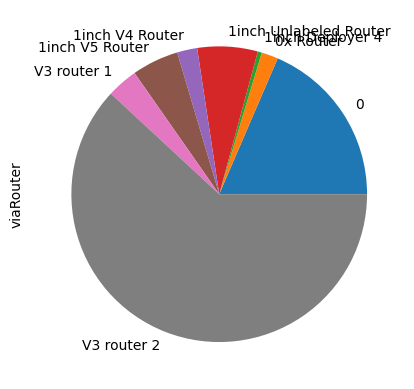

In [248]:
swaps_.groupby("viaRouter")["viaRouter"].count().plot.pie()#.drop(0).plot.pie();
swaps_.groupby("viaRouter")["viaRouter"].count()#.drop(0)

viaRouter
0                         2962.234851
0x Router                   31.506229
1inch Deployer 4            62.183867
1inch Unlabeled Router     169.388150
1inch V4 Router             11.120747
1inch V5 Router             68.596129
V3 router 1                105.560430
V3 router 2                666.996565
Name: amountUSD, dtype: float64


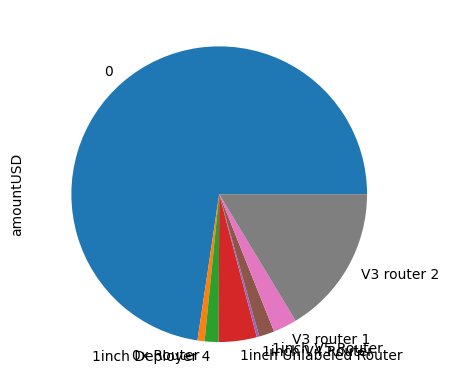

In [243]:
swaps_.groupby("viaRouter")["amountUSD"].sum().plot.pie()
print(100*swaps_.groupby("viaRouter")["amountUSD"].sum()/total_volume_)

In [244]:
swaps_.groupby("viaRouter")["amountUSD"].sum()[[0, "V3 router 1", "V3 router 2"]].sum()

6390048314.572705

In [245]:
total_volume_ = swaps_.amountUSD.sum()
agg_volume_ = total_volume_ - swaps_.groupby("viaRouter")["amountUSD"].sum()[[0, "V3 router 1", "V3 router 2"]].sum()

print(f"Volume that comes from dex aggregators: {100*agg_volume_ / total_volume_:<.2f}%.")


Volume that comes from dex aggregators: 8.41%.


In [246]:
# swaps_.groupby("sender")["amountUSD"].sum().sort_values(ascending=False).head(60) # run this to find the top addresses/aggregators


In [253]:
print(swaps_.sort_values(by="amountUSD", ascending=False)[["amountUSD", "viaRouter", "blockNumber", "txnHash"]].head(20).values)



[[10363632.206013327 0 16207418
  '0x0f2e09bcb98b86cbaebe1a6d1ed5ac3276292b04fba0f08855f38901d80fdd30']
 [10357582.389480827 0 16207418
  '0xb31070502bb38e391639980560605785701f0861bbfdb7c62d55fa5fdd54450b']
 [10128895.509635886 0 16275595
  '0x7829ed4d07fc98d9c7fa66c9bc5852cac8a470267a7dbf9f9328940d7156a5cd']
 [10127718.812992288 0 16275595
  '0xcd421cadfa75ebfd862bf7a9dc8552b1e0138f4d2e451302621a98e724ff404d']
 [9953541.872974586 0 16093512
  '0x00227356f7dbf1c063ac9af11475b5f2d4691ba0f593146615f135aa5bece9f7']
 [9951028.126732586 0 16093512
  '0x85cfad46036ccdd5ddd3905632f5548681f85856b8885da18a9a5cf6ebe63497']
 [9050574.052522207 0 16126113
  '0xe3ff88b34075c5a59f4bb22d590faab145f77f28d70cd792a0fe8389885a47bf']
 [9043187.944646036 0 16126113
  '0x63d759a82ca17b581cc6f45071410689362104d576e1717d0fcca1dc3f115dfd']
 [8950833.085303616 'V3 router 2' 16246331
  '0x5c8bf5d718f850f51352d8743d9a65ccd4bb14334d5217169cc841752e5df2da']
 [8950659.524606287 'V3 router 2' 16246367
  '0x9b8e2d8f3

In [57]:
for i_ in range(1, 11):
    print(swaps_[swaps_.viaRouter == 0].sort_values("amount0").txnHash.iloc[-i_])

0x77f51cdf5a17e094bfa615fcbd60406031fc7e2ade27152715c99a0e77945d1e
0xadee22324378bb1925caf9646bd9ce89224239b1bf35e75f1030afdc14ac6bbf
0x19d1fa0c94a520f544b55575d25bd78f2cfefa033b99bcf8fffdcf796e1053bb
0x283cbf8b7a664b0bc2c7becfb2fbd5be3a4f2853b04b0f7bb87066a64869c2d1
0x3126be5c358c4b7c899e03393e12511978f25370f2535d455e243b98d07e7af5
0x6329781eaf36e7a6c5a62bfef65caf02691ac21ba7eebdc299cf8aa061269c8b
0x9060f3c751e3dca65ca8a60ab69a4abd94b050b1ee79bc19f094b7ea90eeff40
0x270e8c64df95eab90fd652c935bc5def5730da27122b56872199a4b22b8b4bb8
0xc19d05874a519699d844282c341864b175bd2a99a59e3ec16727e5de8811cf36
0xcc1621c5595a535fad768a54cf37b615bedc572cf7b726a9eb2be876013c4673


In [63]:
aave_liquidation_txns_ = set([x.lower() for x in pd.read_csv("./data/aave_txns.csv").txnHash.values])
aave_liquidation_txns_

{'0x7e6175a682f0cbe946e663286869aa06ae6fe4cd0e486d855a663f46c704e27a',
 '0x26cd3ae13c6afc36c798deeb8c15b2f4bd70e90e6e903b83e966d72fc5c1fd51',
 '0x28268a3f62005e8b707b5a6373a1e4ee5a1a476ac7715b58895b178da562c0fd',
 '0xae84502994d7aea1ba08ca9a7a3a98391cf24d37937b6b1706c8a4bf1d5918cb',
 '0xafcdc04891d4427408c556eb8c36a160a561e97248548afd858cda26dcd6c1c5',
 '0x2d98950db314a3520aebd07d0adae41a5bd8c7956708fda0e701320e08bc7881',
 '0xad989466e83d2496d3eeb99ee150256115a3816750042ad9d1b5f8d90c88154f',
 '0x37301438d0f1fcbc2e43da178179660e825d1fb49ab662feeb5bcac5e6249690',
 '0xedcf2e05a2318c20d9c3e7a9785994098d42dba63e234764768e6f5a812d579c',
 '0x5f76dffb8fdc8d9e22103df18054410fcc893a76261b7b7d9fc0c76a42e57354',
 '0x60d5fb255c9c19ba26713f7323156491160286836cfff3941fa8c1a4330d5947',
 '0x72a58e8f85a1d2f34bd7991ec4b19a4aa4a2b0dc576f9dbc5146e7deca6a3c13',
 '0xc54fb7546481e693261964e221825dd20f65fa912d7a7ec1a1f25e2f2448d760',
 '0xf7bd60584a9e75071cf14d6aa09e6eb827d1856ce7c0eed7a5afe381b0bd7a48',
 '0x1b

In [64]:
swap_txns_ = set([x.lower() for x in swaps_.txnHash])
swap_txns_

{'0x9f5fae65ee957f9052848fe492cbe618df37154dc45e4abae18c9af5e2da7870',
 '0xdfdfd24fe8704d85afe4073777daf22b6c1b419f8dde1b4f0d371c29b651ed8d',
 '0xe924ccc636d8f093c4a9cbc265662c686b1380097e32c5f42d8efb57a3103b11',
 '0xaa64f47a7bd903025babb1200941feaf4ccc215766aa8392f2b9eb473f162e17',
 '0x3483e888ad10ddb46503a4486fdd3441cdc681198dc3eb78dae0b0103ea85927',
 '0x37fddfbf9b8b7c7f8f5ce365e459b1f91b27e000cb8cfcd7e2f82eca6c075508',
 '0xb79e2158c27d23b8af0245d915259dec1ec6e2a18e31cf0e5dd0cbb3a4f75409',
 '0x4f82577ec7d83b0be170d9f26738d5ac582bfec5d631a2c4c6f7f52d58c75645',
 '0x9da6de7e5704b75e3de73834e32b6ad1d0b0658fd65390dfeeed1ec7050845f2',
 '0x7654b2592b4b00d31b3c58cbb76d54d24edadb3eb823989bd5ee62ba718f0991',
 '0x4d860a5ec4b88be2647867a4dc4007e7678a87d4fc8e0a3ad56a4a2b5478be4f',
 '0x7d9fe454f9836e3996908df6905419d7be14754ca9d51af9e8b14223f6ba9327',
 '0xe87f76e22ff4aac2f806ee7304699511a9f313225caa364c680c94059a799c01',
 '0x70b4ad35320482700e6e354d315cdb25ab22a9175fe836775f99cb69c69541b0',
 '0x02

In [65]:
swap_txns_.intersection(aave_liquidation_txns_)

{'0x012f76f924aa1deb6366402460572b7748c603937bce99aed3b23e61bbb40182',
 '0x0e90516244ce2d468dd0bef5701281169cbee37a05cf70fa821148b3c503c1ed',
 '0x178a45df930f61856c8ab00685fd4317d408bc5221a2743148f200d94b009927',
 '0x32b002924b5d43c2cad4dcccb49f0beb7335cc328d7dd9a86ffd4922194c4b8b',
 '0x341babd1d3b6ad91b0e960400257fa7bd0c65ce26ca9c3e2c8b11d13fbefc039',
 '0x49ed18d5bffb7a18b194775d9f920142eb9fbf02f8ed18052bf46b9ac27b1129',
 '0x663b767951f8064627feb14cf1a19710c749a763310b301b96af27f5db4c5d21',
 '0x68107a797ef896900b5bceff50f08db1adae7cb9c6c342c49b67c911e22f8ebc',
 '0x6ff9ce89bef58b4d27297509e6bd1456980525064b927fb156be512d8d2ed72a',
 '0x75a5f967329b9593025d3ba70c3ef3dfc745f0bd1db04fb7e4b1aabd20566043',
 '0x8024589c78bedaa9b61c98808fae727fd69e98eaa56f52eaddac93776e4424bb',
 '0xa3cebf0da1e6bbff5ac9dfee488c00b3cb632cb4375311262989da3fd3d296ef',
 '0xac12911663523b98bd598749ee7838220d2441383aad44d74b6a12ccf7e53188',
 '0xb115135fc4e0409633cf3b9c7853cd3d11b0b6e97d598bd25f18ed1891249374',
 '0xbe

In [70]:
swaps_[swaps_.txnHash.apply(lambda x: x in aave_liquidation_txns_)].sort_values("amount0").amount0.abs().sum()

213514.19259

In [71]:
swaps_.amount0.abs().sum()

4790768962.460006

In [95]:
print(f"Percent of volume that comes through aave liquidations: {100*213514.19259/4790768962.460006:,.4f}%.")

Percent of volume that comes through aave liquidations: 0.0045%.
